# Introduction

For this exercise, I choose the voice dataset. This dataset was created to identify a voice as male or female, based upon acoustic properties of the voice and speech. The dataset consists of 3,168 recorded voice samples, collected from male and female speakers. The voice samples are pre-processed by acoustic analysis in R using the seewave and tuneR packages, with an analyzed frequency range of 0hz-280hz.

### Goal: 
My goal is to make a model that predicts wether a voice recording is labeled as male or female.
To achieve this goal, I choose the following variables:
* meanfreq
* sd
* median
* IQR
* dfrange
* meanfun
* meandom

I choose these variables because I think that these give an accurate representation of all the facets of a human voice.

In [1]:
import seaborn as sns
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression #remember, this is linear regression model from sk-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('voice.csv')
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [3]:
df_subset = df[['meanfreq', 'sd', 'median', 'IQR','dfrange','meanfun','meandom','label']]

# Data cleaning

In [4]:
df_subset.isna().sum()

meanfreq    0
sd          0
median      0
IQR         0
dfrange     0
meanfun     0
meandom     0
label       0
dtype: int64

There are no missing values in the dataset.

# Exploratory data analysis

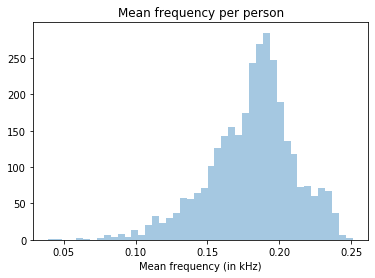

In [5]:
sns.distplot(df['meanfreq'].dropna(), kde=False)
plt.title('Mean frequency per person')
plt.xlabel('Mean frequency (in kHz)')
plt.show()

The meanfreq follows an unimodal, left-tailed distribution

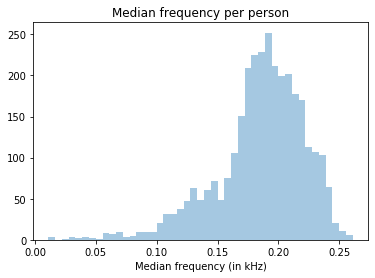

In [6]:
sns.distplot(df['median'].dropna(), kde=False)
plt.title('Median frequency per person')
plt.xlabel('Median frequency (in kHz)')
plt.show()

The median frequency follows an unimodal, left-tailed distribution

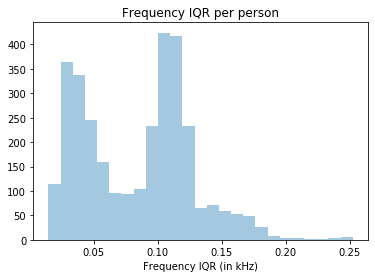

In [7]:
sns.distplot(df['IQR'].dropna(), kde=False)
plt.title('Frequency IQR per person')
plt.xlabel('Frequency IQR (in kHz)')
plt.show()

The IQR range follows an bimodal, right-tailed distribution.
These 2 modes could represent the males and the females.

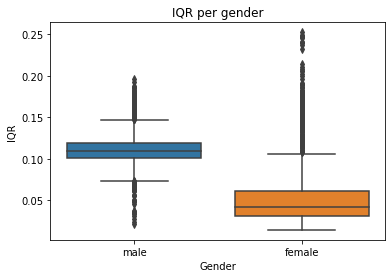

In [8]:
sns.boxplot(x='label', y='IQR', data=df)
plt.title('IQR per gender')
plt.xlabel('Gender')
plt.show()

In the boxplot, we see that males have a higher median value for IQR range voice frequency than females.

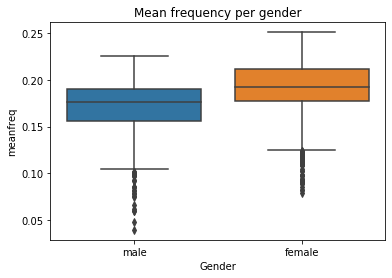

In [9]:
sns.boxplot(x='label', y='meanfreq', data=df)
plt.title('Mean frequency per gender')
plt.xlabel('Gender')
plt.show()

In the boxplot, we see an IQR of the mean frequency between 0.11 and 0.25, with some outliers between 0.01 and 0.011.
We also see that females have a higher median voice frequency than males.

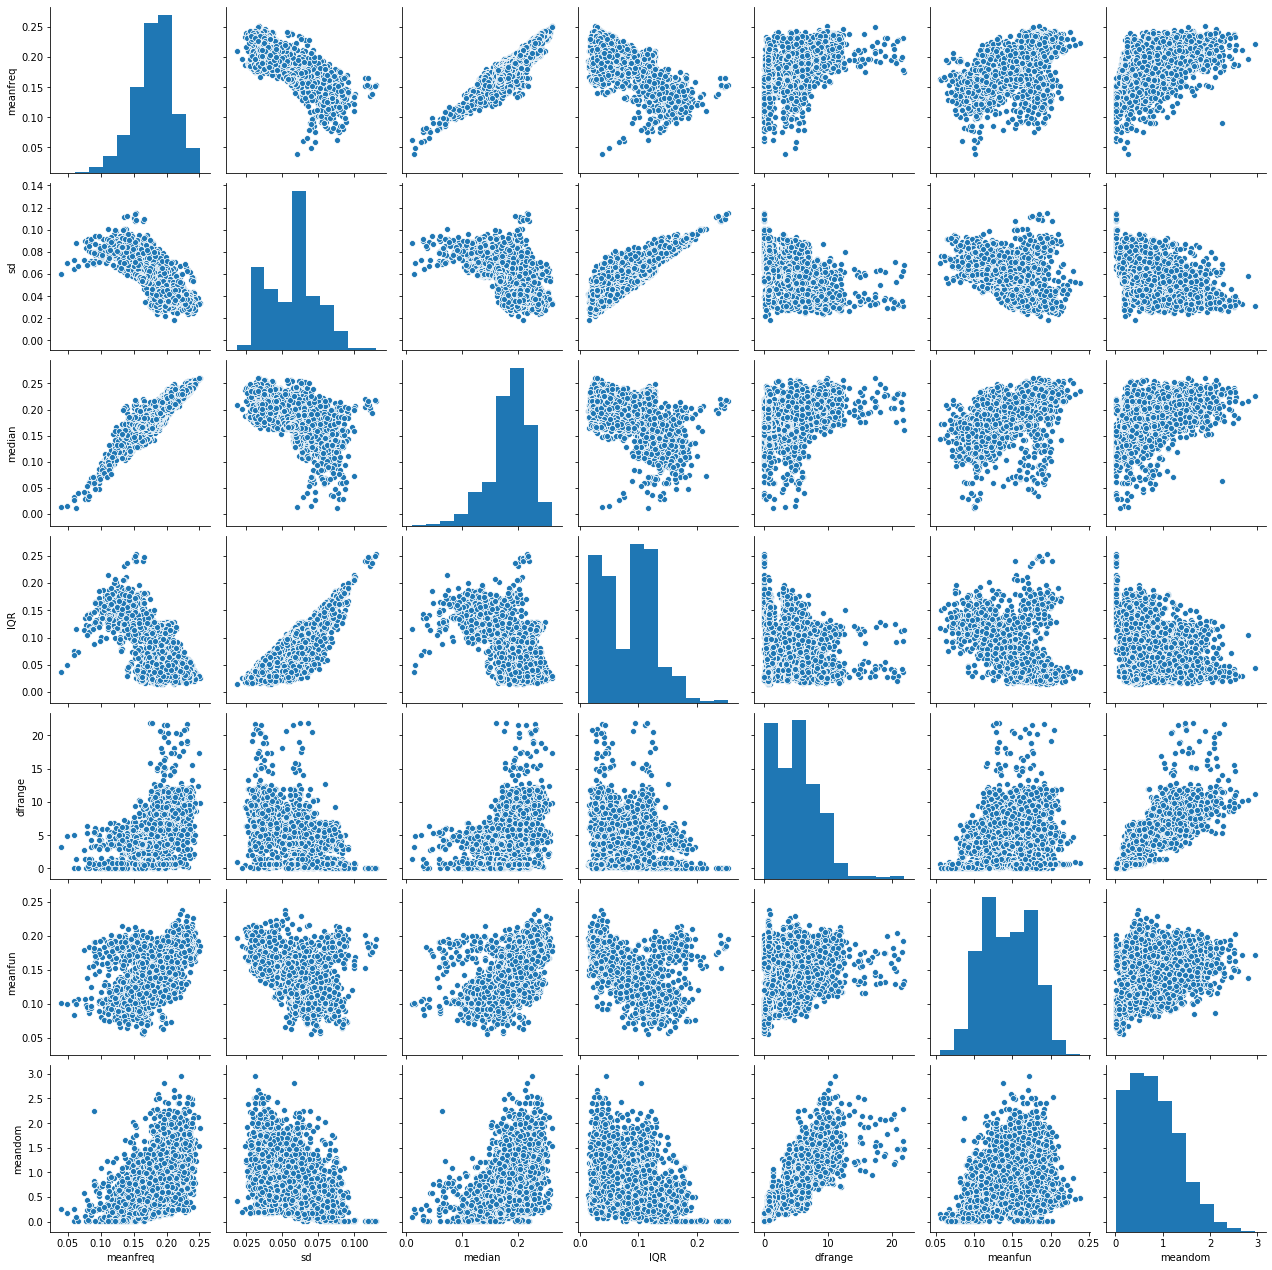

In [10]:
sns.pairplot(df_subset)

In [11]:
df_subset.corr()

,meanfreq,sd,median,IQR,dfrange,meanfun,meandom
meanfreq,1.000000,-0.739039,0.925445,-0.627605,0.515570,0.460844,0.536666
sd,-0.739039,1.000000,-0.562603,0.874660,-0.475999,-0.466281,-0.482726
median,0.925445,-0.562603,1.000000,-0.477352,0.435621,0.414909,0.455943
IQR,-0.627605,0.874660,-0.477352,1.000000,-0.331563,-0.534462,-0.333362
dfrange,0.515570,-0.475999,0.435621,-0.331563,1.000000,0.275154,0.811304
meanfun,0.460844,-0.466281,0.414909,-0.534462,0.275154,1.000000,0.270840
meandom,0.536666,-0.482726,0.455943,-0.333362,0.811304,0.270840,1.000000


In the correlation matrix, we can see that there are the following strong correlations:
* negative correlation between meanfreq and sd 
* negative correlation between meanfreq and IQR
* positive correlation between meanfreq and median
* positive correlation between IQR and sd
* positive correlation between meandom and dfrange


Predictive model
Choose one of the following: k-nearest neighbor or random forest
Explain briefly in your own words how the algorithm works
Split the data set into a training and test set
Train the model
Evaluation
Calculate the accuracy, precision and recall. Describe and interpret the results in a Markdown cell.
Conclusion

# Predictive model
For the next step, I'm going to use a k-nearest neighbor model to predict if the voice recordings belong to a male or a female.
This model independently chooses which cases (rows) are considered neighbors, and does this per row. The number of neighbors is defined by the user. The neighbors are chosen based on the values in the rows, which have to be approximatly corresponding with the rows in the current case. If this is the case, then the dependent variable of the current row is calculated, based on the values of the dependent variable of the neighbors. 

First, define the X variable (independent variables)

In [14]:
from sklearn.preprocessing import normalize 

X = df_subset[['meanfreq', 'sd', 'median', 'IQR','dfrange','meanfun','meandom']]
X = normalize(X)

Second, define the Y variable (dependent variable)

In [15]:
y = df_subset['label']

Then, split the data into test and training data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

Define and train the KNN model

In [27]:
from sklearn.neighbors import KNeighborsClassifier #the object class we need

knn = KNeighborsClassifier(n_neighbors=5) #create a KNN-classifier with 5 neighbors (default)
knn = knn.fit(X_train, y_train) #this fits the k-nearest neigbor model with the train data

Print the accuracy score:

In [28]:
knn.score(X_test, y_test) #calculate the fit on the test data

0.9232386961093586

# Evaluation of the model

Create a confusion matrix

In [29]:
from sklearn.metrics import confusion_matrix
y_test_pred = knn.predict(X_test) #the predicted values
cm = confusion_matrix(y_test, y_test_pred) #creates a "confusion matrix"
cm

array([[416,  41],
       [ 32, 462]], dtype=int64)

In [30]:
knn.classes_

array(['female', 'male'], dtype=object)

In [31]:
conf_matrix = pd.DataFrame(cm, index=['female', 'male'], columns = ['female_p', 'male_p']) 
conf_matrix

,female_p,male_p
female,416,41
male,32,462


Calculate precision and recall for predicting males:
    
$precision = \frac{462}{462 + 32} = .935$

$recall = \frac{462}{462 + 41} = .918$

Calculate precision and recall for predicting females:
    
$precision = \frac{416}{416 + 32} = .928$

$recall = \frac{416}{416 + 41} = .910$

# Conclusion

In this exercise, we created a machine learning model to predict if characteristics of a voice recording belong to a male or a female voice.
We trained the KNN model with n=5 on 3,168 recorded voice samples.
This gave us the following results:
* Predicting males with a precision of 93.5% and a recall of 91.8%
* Predicting females with a precision of 92.8% and a recall of 91%

Overall, this model perfomed very good (regarding the precision and recall) at predicting male and female voices.